<a href="https://colab.research.google.com/github/nightted/Travel-Recommend-project/blob/main/Googlemap_Store_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A project to recommend the hotels according to the surrounding stores and attractions


1.  根據 All餐廳s + All 便利商店s "密度" (有人 Prefer "安靜" , 有人愛 "鬧區與便利"), 以及想吃&去的 target store 位置( EX: 牛肉湯,肉燥飯,觀光景點,網美餐廳...) & 密度來選擇住的區域 (還在發想要不要加入 ratings 來做選擇的 weighting)
2.  選擇區域後 , 再根據區域內 target store 分布 , 以及機能密度 , 以及"想去的景點"(演算法待想) , 來選擇區域內的一個 center 來當搜尋中心點. 
3.  根據中心點 , 抓初 circle 範圍內一定的推薦數量(User control)的 hotels , 並根據 user 所設的 criteria ( ratings , 民宿or飯店類型 ...) 來 filter hotels 
4. 從 booking 爬取及時房況 (直接一間一間 POST filter 出來的 hotels ?) 並呈現在頁面上.


#TODO LIST
1. #TODO : sightseeing spot and 網美景點 (Done)
2. #TODO : 決定選區演算法 (Done , see current idea)
3. #TODO : 把 store data class 化的必要?
*  Current idea :

*   step.1 算出美食與便利店密度, 當作機能指標 (Done , 11/6 新增 rating_depent ,
      11/7 修改 grid_generator 新增 'normal' mode)
*   step.2 尋找機能密度 peak , 抓出前幾大 peak 的位置 (這邊如果有加入想去的景點選
      項, peak 選擇可加入此條件考量 , EX: 離景點最近的 peak) 
*   step.3 找到 peak 後 , 按 peak 所在的 grid 做上下左右的搜索 , 並設置 target 
      S =  機能密度 x 想吃的食物數目(要考慮評價 ,利用 radius search)  

3. #TODO : 飯店附近推薦美食 , 需用 googlesearch package 來抓google搜尋blog結果 



In [2]:
!pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-4.4.2-cp36-none-any.whl size=37858 sha256=7c521b067b39c1fcedf2a937d0c233ba1edb64766534723dbebe6d2ab69b4c3e
  Stored in directory: /root/.cache/pip/wheels/f4/21/41/0c84572e21d52bb322f6c299f38ac7cd8ad6d4d6ce23dc3631
Successfully built googlemaps


In [3]:
import googlemaps
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from sklearn.cluster import KMeans
import time 
import os 
import seaborn as sns
import math 
from functools import partial , reduce  
import requests
from bs4 import BeautifulSoup

key_path = '/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/API_KEY/API_KEY.txt'
storage_path = '/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan'
lng_1 = 102.516520*1000 # 1 longitude to meters
lat_1 = 110.740000*1000 # 1 latitude to meters

In [37]:
# Loading data

def save_pkl(path  , data):
    with open(path , "wb") as pkl :
        pickle.dump(data , pkl)
        
def load_pkl(path):
    with open(path , "rb") as pkl :
        data = pickle.load(pkl) 
    return data
    
grid_to_latlng = load_pkl('/content/drive/My Drive/Colab Notebooks/Travel Recommend Project/City data/Tainan/Gird_to_latlng/grid_to_latlng')
data_train_station = load_pkl(os.path.join(storage_path ,'data_train_station'))
#data_hotel = grab_nearby_point( '飯店' , location , radius = 200 , ranging = 5 , data = data_hotel ) #飯店 store
data_hotel = load_pkl(os.path.join(storage_path ,'data_hotel'))
#data_rest = grab_nearby_point('餐廳', location , 400) #餐廳 store
data_rest = load_pkl(os.path.join(storage_path ,'data_rest'))
#data_beefsoup = grab_nearby_point('牛肉湯', location , 1000) #牛肉湯 store
data_beefsoup = load_pkl(os.path.join(storage_path ,'data_beefsoup'))
#data_porkrice = grab_nearby_point('肉燥飯', location , 1000) # 肉燥飯 store
data_porkrice = load_pkl(os.path.join(storage_path ,'data_porkrice'))
#data_EelNoodles = grab_nearby_point('鱔魚意麵', location , 1000 , ranging = 2) # 鱔魚意麵 store 
data_EelNoodles = load_pkl(os.path.join(storage_path ,'data_EelNoodles'))
#data_gruel = grab_nearby_point('鹹粥', location , 1000 , ranging = 2) # 鹹粥 store 
data_gruel = load_pkl(os.path.join(storage_path ,'data_gruel'))
#data_nightmarket = grab_nearby_point('夜市', location , 1000) # 夜市 store
data_nightmarket = load_pkl(os.path.join(storage_path ,'data_nightmarket'))
#data_con = grab_nearby_point('便利商店', location , 1000) # 便利商店 store
data_con = load_pkl(os.path.join(storage_path ,'data_con'))
data_sightseeing = load_pkl(os.path.join(storage_path ,'data_sightseeing'))

In [ ]:
# Saving Data
#save_pkl(os.path.join(storage_path ,'data_train_station') , data_train_station)
#save_pkl(os.path.join(storage_path ,'data_rest') , data_rest)
#save_pkl(os.path.join(storage_path ,'data_beefsoup') , data_beefsoup)
#save_pkl(os.path.join(storage_path ,'data_nightmarket') , data_nightmarket)
#save_pkl(os.path.join(storage_path ,'data_porkrice') , data_porkrice)
#save_pkl(os.path.join(storage_path ,'data_con') , data_con)
#save_pkl(os.path.join(storage_path ,'data_hotel') , data_hotel)
#save_pkl(os.path.join(storage_path ,'data_sightseeing') , data_sightseeing)
#save_pkl(os.path.join(storage_path ,'data_gruel') , data_gruel)
#save_pkl(os.path.join(storage_path ,'data_EelNoodles') , data_EelNoodles)

In [15]:
def read_key(key_path):
  with open(key_path , 'r') as f:
    KEY = f.read()
  return KEY
  
# generate grid of position by radius
def grid_generator( location , radius , ranging , mode = "max_area"):
    
    '''
    # function : generate search points (grid)

    location : search center (grid start generating from this point) 

    radius : interval between grid point

    ranging : number of search points to generate in top,bottom,left,right ( 1 ranging equal to generate 2 points about 1 radius interval in "full-cover" mode)


    @ is scan point in grid

    mode 'normal : @--2*r--@--2*r--@--2*r--@--2*r--@ 
             @--2*r--@--2*r--@--2*r--@--2*r--@

    mode 'max_area' :    @--2*r--@--2*r--@--2*r-- 
                --2*r--@--2*r--@--2*r--@

    mode 'full_cover' :  @-r-@-r-@-r-@-r-@ 
                @-r-@-r-@-r-@-r-@ 

    '''

    rg = [ i for i in range(ranging,-(ranging+1),-1) ] #　get list between [int , -int]
    grid_delta_lng = radius / lng_1 # unit transform between meter and lat,lng  ( 1000m radius <=> 0.01 lag ,lng )
    grid_delta_lat = radius / lat_1

    lng , lat = location['lng'] , location['lat']
    # get the grids 
    grid_outer = [ {'lng': lng + grid_delta_lng *2* lng_delta , 'lat': lat + grid_delta_lat *2* lat_delta } for lng_delta in rg for lat_delta in rg ]

    if mode == 'max_area':
      grid_inner = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      
      return grid_outer + grid_inner

    if mode == 'full_cover':
      grid_inner = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      grid_down = [ {'lng': dicts['lng']  , 'lat': dicts['lat'] - grid_delta_lat } for dicts in grid_outer ]
      grid_aside = [ {'lng': dicts['lng'] - grid_delta_lng  , 'lat': dicts['lat']  } for dicts in grid_outer ] 

      return grid_outer + grid_inner + grid_down + grid_aside

    return grid_outer 

# get store information with location , keyword , search radius  
def get_store_nearby( keyword , location ,  radius , next_page_token , data ):

    '''
    # function : get stores with keyword in some radius

    keyword : keyword of store you want to search 

    location : search center 

    radius : search radius

    next_page_token : to get data of page 20~40 , 40~60  

    data : data already storage 
    '''
    
    if data == None:      
        data = []

    res = maps.places_nearby( page_token = next_page_token , keyword = keyword , location = location , radius = 1000 )   #get stores list nearby   
    for store_inform in res['results']:

        lat_lng = store_inform['geometry']['location']
        lat , lng = lat_lng['lat'] , lat_lng["lng"]
        store_name = store_inform['name']
        rating = store_inform.get('rating',None)

        information = {'location' : [lng , lat] , 
                  'store_name' : store_name, 
                  'rating' : rating } 

        if rating and information not in data: # discard None-rating store
            data.append(information)
        
    next_page_token = res.get( 'next_page_token' , None) # get if token exsit or return None 

    return next_page_token , data

# get store information with location , keyword , search radius (plus the change pages and move search location)
# 1 ranging is across 2 * radius in each sides  
# EX : radius = 1000 , ranging = 1 , so the spanning region is 2000 in top,bottom,left,right directions , total scan area = 4000 X 4000 .
def grab_nearby_point( keyword , search_center ,  radius , ranging , next_page_token = None , data = None ):

    '''
    # function : get stores with keyword in range of grid

    keyword : keyword of store you want to search 

    location : search center 

    radius : search radius

    next_page_token : to get data of page 20~40 , 40~60  

    data : data already storage 
    '''
    
    
    for idx , location in enumerate(grid_generator(grid_center , radius , ranging )): 

        print(f'finish [{idx+1}/{len(grid_generator(grid_center , radius , ranging))}] parts !')       
        while True : # change page
            next_page_token , data = get_store_nearby( keyword , location ,  radius , next_page_token = next_page_token , data = data )
            if next_page_token == None :
                break
            time.sleep(3) #set time sleep to avoid request too often !
    return data   

# store weighting
def rating_modify(rating):
    
    if  4.8 < rating <= 5.0 :
        score = 512.0
    elif 4.6 < rating <= 4.8 :
        score = 256.0
    elif 4.4 < rating <= 4.6 :
        score = 128.0
    elif 4.2 < rating <= 4.4 :
        score = 64.0
    elif 4.0 < rating <= 4.2 :
        score = 32.0
    elif 3.8 < rating <= 4.0 :
        score = 16.0
    elif 3.6 < rating <= 3.8 :
        score = 8.0
    elif 3.4 < rating <= 3.6 :
        score = 4.0
    elif 3.2 < rating <= 3.4 :
        score = 2.0
    else:
        score = 1.0
    
    return score

def distance(a , b):

    '''
    get distnace of two point (in unit of meter)
    '''
    a_x , a_y = a[0] , a[1]
    b_x , b_y = b[0] , b[1]
    delta_x_meter = (a_x-b_x)*lng_1
    delta_y_meter = (a_y-b_y)*lat_1

    return ((delta_x_meter)**2 + (delta_y_meter)**2 )**0.5

In [6]:
# grab the store contain some keyword (ex: 扁食)
def grab_keyword_store( data , keyword = ''):

  '''
  # function : transform data to numpy

  keyword : to filter keyword in store_name
  '''
 
  x ,y , x_y , rat , name = [] , [] , [] , [] , []
  for item in data:
    if keyword in item["store_name"] : # if keyword == None , grab all stores
      x.append(item['location'][0])
      y.append(item['location'][1])
      x_y.append(item['location'])
      #rat.append(rating_modify(item['rating'])) # rating func 要修正XD , EX: 4.8~5.0 => 10 分 , 4.6~4.8 => 9 分 , ... , < 3.0 => 1分
      rat.append(item['rating'])
      name.append(item['store_name'])

  return x , y , x_y , rat ,name

In [16]:
GOOGLE_API_KEY = read_key(key_path)
maps = googlemaps.Client(key = GOOGLE_API_KEY)

In [17]:
position = ['春川煎餅']
result = maps.geocode(position)
location = result[0]['geometry']['location']

In [18]:
location

{'lat': 22.9913113, 'lng': 120.198012}

In [11]:
'''
positions = ['台南火車站']
data_train_station = []
for idx ,position in enumerate(positions):

  results = maps.geocode(position)
  place_deatil = maps.place( place_id= results[0]['place_id'])

  lat_lng = place_deatil['result']['geometry']['location']
  lat , lng = lat_lng['lat'] , lat_lng["lng"]
  rating = place_deatil['result']['rating']
  rating_num = place_deatil['result']['user_ratings_total']

  data_train_station.append({'location' : [lng , lat] ,
               'rating' : rating ,
              'store_name' : position
                         })
'''          

'\npositions = [\'台南火車站\']\ndata_train_station = []\nfor idx ,position in enumerate(positions):\n\n  results = maps.geocode(position)\n  place_deatil = maps.place( place_id= results[0][\'place_id\'])\n\n  lat_lng = place_deatil[\'result\'][\'geometry\'][\'location\']\n  lat , lng = lat_lng[\'lat\'] , lat_lng["lng"]\n  rating = place_deatil[\'result\'][\'rating\']\n  rating_num = place_deatil[\'result\'][\'user_ratings_total\']\n\n  data_train_station.append({\'location\' : [lng , lat] ,\n               \'rating\' : rating ,\n              \'store_name\' : position\n                         })\n'

In [19]:
x_rs , y_rs , x_y_rs , rating_rs , name_rs = grab_keyword_store(data_rest) # All 餐廳s
x_tr , y_tr , x_y_tr , rating_tr , name_tr = grab_keyword_store(data_train_station)             # train station 
x_bf , y_bf , x_y_bf , rating_bf , name_bf = grab_keyword_store(data_beefsoup , "牛肉湯")         # 牛肉湯
x_nm , y_nm , x_y_nm , rating_nm , name_nm = grab_keyword_store(data_nightmarket , 'Night Market')    # 夜市
x_pr , y_pr , x_y_pr , rating_pr , name_pr = grab_keyword_store(data_porkrice , '肉燥飯')         # 肉燥飯
x_cn , y_cn , x_y_cn , rating_cn , name_cn = grab_keyword_store(data_con)                  # 便利超商
x_h , y_h , x_y_h , rating_h , name_h = grab_keyword_store(data_hotel)                    # 飯店 
x_sight , y_sight , x_y_sight , rating_sight , name_sight = grab_keyword_store(data_sightseeing)       # 觀光景點
x_Eel , y_Eel , x_y_Eel , rating_Eel , name_Eel = grab_keyword_store(data_EelNoodles)            # 鱔魚意麵
x_gru , y_gru , x_y_gru , rating_gru , name_gru = grab_keyword_store(data_gruel)               # 鹹粥

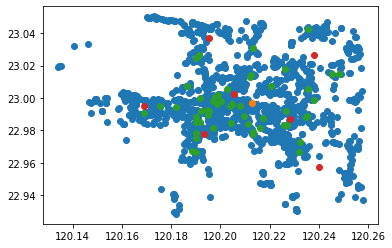

In [24]:
plt.scatter(np.array(x_y_rs)[:,0],np.array(x_y_rs)[:,1])    # 餐廳
#plt.scatter(np.array([location['lng']]) , np.array([location['lat']])  ) # 台南火車站
#plt.scatter(np.array(x_y_bf)[:,0],np.array(x_y_bf)[:,1]) # 牛肉湯
#plt.scatter(np.array(x_y_nm)[:,0],np.array(x_y_nm)[:,1]) # 夜市
#plt.scatter(np.array(x_y_pr)[:,0],np.array(x_y_pr)[:,1]) # 肉燥飯
#plt.scatter(np.array(x_y_cn)[:,0],np.array(x_y_cn)[:,1]) # 便利商店
plt.scatter(np.array(x_y_tr)[:,0],np.array(x_y_tr)[:,1]) # train station
plt.scatter(np.array(x_y_Eel)[:,0],np.array(x_y_Eel)[:,1]) # Hotel
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])

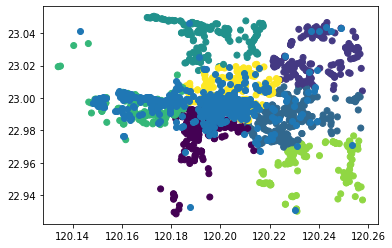

In [25]:
# plot the KM of daily demands store and calculate each cluster center 
kmeans = KMeans(n_clusters=7).fit(x_y_rs)
plt.scatter(np.array(x_y_rs)[:,0],np.array(x_y_rs)[:,1], c=kmeans.labels_)
#plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
plt.scatter(np.array(x_y_h)[:,0],np.array(x_y_h)[:,1])

#plt.scatter(np.array(x_y_cn)[:,0],np.array(x_y_cn)[:,1])
#plt.scatter(np.array(x_y_nm)[:,0],np.array(x_y_nm)[:,1])

# Grouping the stores


In [26]:
[ [f'Group: {idx} ,', center ]  for idx , center in enumerate(kmeans.cluster_centers_)]

[['Group: 0 ,', array([120.19347102,  22.97808337])],
 ['Group: 1 ,', array([120.23780087,  23.02699732])],
 ['Group: 2 ,', array([120.22860748,  22.98752553])],
 ['Group: 3 ,', array([120.19532757,  23.03690482])],
 ['Group: 4 ,', array([120.1690571 ,  22.99526288])],
 ['Group: 5 ,', array([120.23990803,  22.95767118])],
 ['Group: 6 ,', array([120.20533248,  23.00215255])]]

In [27]:
# grouping the x_y data by KM result to specified group 
def Grouping_data_by_zone(data , KM_label , group ): 

  return [ ele for idx , ele in enumerate(data) if KM_label[idx] == group ]
  
# grouping the target stores by KM result 
def Grouing_target_store_by_zone(x_y_target , KM_center):

  cluster_num = len(KM_center)
  group = np.zeros(len(x_y_target))

  for store_idx , position in enumerate(x_y_target):
    min = 1000000000
    for center_idx , cluster_center in enumerate(KM_center): 
      if distance(position , cluster_center) < min :
        min = distance(position , cluster_center)
        group_idx = center_idx

    group[store_idx] = group_idx
  return group

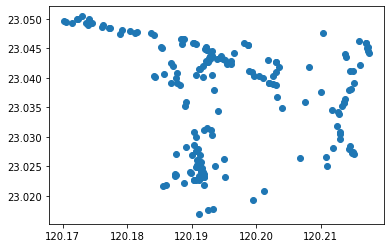

In [28]:
data = x_y_rs
group_idx = 3

x_y_g = Grouping_data_by_zone(data , kmeans.labels_ , group_idx )
plt.scatter(np.array(x_y_g)[:,0],np.array(x_y_g)[:,1])

In [29]:
target_store_label = Grouing_target_store_by_zone( x_y_rs , KM_center = kmeans.cluster_centers_ ) # get the grouping label of target store
store_rating_by_label = [ Grouping_data_by_zone( rating_rs , target_store_label , i ) for i in range(len(kmeans.cluster_centers_)) ] # by the grouping label , get the store ''information'' by zone
store_rating_by_label_ave = [ np.average(np.array(rating_score)) for rating_score in store_rating_by_label ] # rating ave. of every zone 
store_rating_by_label_ave

[4.306976744186047,
 4.229130434782609,
 4.3091205211726376,
 4.1866666666666665,
 4.2945,
 4.1988304093567255,
 4.301086956521739]

In [30]:
g = 6
store_name_by_label = [ Grouping_data_by_zone( name_rs , target_store_label , i ) for i in range(len(kmeans.cluster_centers_)) ]
#for name , rat in zip(store_name_by_label[g] , store_rating_by_label[g]):
  #print(f' The store name : {name} , and rating is : {rat}')

TypeError: ignored

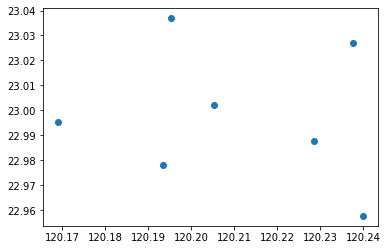

In [31]:
# plot the grouping result of target stores
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
plt.scatter(x_y_bf[:,0] , x_y_bf[:,1] , c=group)

In [32]:
# calculate the foucs_center where "best-food" is clutering at 
# TODO: need to modify due to new definition of target and surrounding stores
x_focus , y_focus = (x*rating).sum() / rating.sum() , (y*rating).sum() / rating.sum()
x_focus , y_focus

NameError: ignored

# Density calculate

In [54]:
# initialize items => name , source_name(after name-matching) , location , google_rating
class Store(object):

  def __init__(self , store_type = None , dicts = None):

    self.store_type = store_type
    if dicts is not None:
      self.construct_attr_by_dict( dicts )
  
  def construct_attr_by_dict(self , store_dict):
    
    # basic property
    self.name = store_dict['store_name']
    self.location = store_dict['location']
    self.rating = store_dict['rating']

  def __repr__(self):
    return f'{self.name} is at {self.location} and rating {self.rating} in googlemap '


class Hotel(Store):

  def __init__(self , store_type = 'hotel' , dicts = None):
    super().__init__( store_type , dicts )

  
  def construct_attr_by_dict(self , store_dict):
    super().construct_attr_by_dict( store_dict )

    if 'room_source' in store_dict.keys():

      self.room_source = store_dict['room_source']
      self.source_name = store_dict['source_name']

      if self.room_source == 'booking':
        
        if 'href' in store_dict.keys(): # check one of the keys is in dict
          self.detail_href = store_dict['href']
          self.comment_num = store_dict['comment_num']
          self.star = store_dict['stars']
          self.pic_link = store_dict['pic_link']
          self.source_rating = store_dict['source_rating']

          self.pics = store_dict['pics']
          self.comments = store_dict['comments']
        else:
          print('Not contains more information !')

      elif self.room_source == 'agoda':
        pass
      else:
        pass

  def construct_attr_by_request(self , date = None , instant = True):
    
    # return [ hotel_room_recommend , hotel_room_remainings , hotel_hot , hotel_price , hotel_instant_hrefs]
    if instant:

      instant_dict = get_hotel_information( self.source_name , date = date ,  instant_information = True ) 
      
      self.room_recommend = instant_dict['room_recommend'] 
      self.room_remainings = instant_dict['room_remainings'] 
      self.hot = instant_dict['hot']
      self.price = instant_dict['price']
      self.instant_hrefs = instant_dict['instant_hrefs']
    
    else:
      static_dict = get_hotel_information( self.source_name , date = date ,  instant_information = False )
      
      self.detail_href = static_dict['href']
      self.comment_num = static_dict['comment_num']
      self.star = static_dict['stars']
      self.pic_link = static_dict['pic_link']
      self.source_rating = static_dict['source_rating']
      
      static_dict_deatil = get_detail_hotel_information( self.detail_href )

      self.pics = static_dict_deatil['pics']
      self.comments = static_dict_deatil['comments']

  def __repr__(self):
    return super().__repr__()
    
    

In [ ]:
# TODO : Transfer hotel data dicts into objects 

In [44]:
url = "https://www.booking.com/searchresults.zh-tw.html"

#INPUT type scrape_time : ['2020-12-09' ,'2020-12-10']
def get_header_payload(scrape_time , target_hotel = None ):

  '''
  # function : get the headers and payload by scrape time

  target_hotel : if it's not assigned , scarpe all "台南" hotel 

  '''

  check_in_time = scrape_time[0].split('-')
  check_out_time = scrape_time[1].split('-')
  
  payload = {
    'checkin_year': check_in_time[0] ,
    'checkin_month': check_in_time[1] ,
    'checkin_monthday': check_in_time[2] ,
    'checkout_year': check_out_time[0] ,
    'checkout_month': check_out_time[1] ,
    'checkout_monthday': check_out_time[2] ,
    'aid': '1288258', # need or not?
    'label': 'label: metagha-link-mapresultsTW-hotel-2468603_dev-desktop_los-1_bw-18_dow-Monday_defdate-0_room-0_lang-zh_curr-TWD_gstadt-2_rateid-0_aud-0_cid-_gacid-6642513825_mcid-10_ppa-0_clrid-0_ad-1_gstkid-0', # need or not?
    'sid': 'ab79516c4eea1e96b378b9c2338022ce', # need or not?
    'sb': '1', # need or not?
    'src': 'searchresults', 
    'src_elem': 'sb', # need or not?
    'ss': target_hotel if target_hotel else '台南', 
    'ssne': None if target_hotel else '台南', # place you want to search (encode)
    'ssne_untouched': None if target_hotel else '台南' , # place you want to search (encode)
    'is_ski_area': '0', # need or not?
    'dest_type': None if target_hotel else 'city', 
    'dest_id': None if target_hotel else '-2637868', # place id you want to search 
    'group_adults': '2', # number of people
    'group_children': '0', # number of children
    'no_rooms': '1', # number of rooms
    'from_sf': '1', # ???
    'ac_langcode': 'xt'

  }

  headers = {    
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36', # can be generate fake agent ??
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'error_url': "https://www.booking.com/index.zh-tw.html?aid=1288258;label=metagha-link-mapresultsTW-hotel-2468603_dev-desktop_los-1_bw-18_dow-Monday_defdate-0_room-0_lang-zh_curr-TWD_gstadt-2_rateid-0_aud-0_cid-_gacid-6642513825_mcid-10_ppa-0_clrid-0_ad-1_gstkid-0;sid=ab79516c4eea1e96b378b9c2338022ce;sb_price_type=total;srpvid=f1b826d7eb680028&;",
    'content-security-policy-report-only': "report-uri https://csp-receiver.booking.com/csp_violation?type=report&tag=112&pid=040f2610ef80010a&e=UmFuZG9tSVYkc2RlIyh9YRdubXl3m7MIPItwv4TRRzARPrDvNuzlrbfIvmyYAyhkeKKOaHLiHXalz9oYwBjSNw&f=2&s=0; frame-ancestors 'none';",
    'Referer' : 'https://www.booking.com/index.zh-tw.html?aid=376396&label=booking-name-yefrPbbyS%2AFIINHgyCnmNgS267725091255%3Apl%3Ata%3Ap1%3Ap22%2C563%2C000%3Aac%3Aap%3Aneg%3Afi%3Atikwd-65526620%3Alp1012818%3Ali%3Adec%3Adm%3Appccp%3DUmFuZG9tSVYkc2RlIyh9YfqnDqqG8nt1O4nYvDr1lms&sid=99dd5960476d5bf057cf94fe33e3deb6&srpvid=6d1e3723a19e0104&click_from_logo=1',
    'Host': 'www.booking.com',    
    'Upgrade-Insecure-Requests': '1',
    'Accept-Language': 'zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1' ,
    'Connection': 'keep-alive'
  }
  
  return payload , headers

# check target information in search result or not
def check_alive_or_not( search_result , text = True , tag  = None , msg_if_none = None ):
  '''
  text : if True , get text in tag ; if False , get tag property

  tag : if not none , get property of that tag
  '''
  if not search_result:
    return msg_if_none
  return search_result.text if text else search_result[tag]


# get information of hotels
def get_hotel_information( hotel_name , date = None ,  instant_information = False ):

  '''
  #function : get hotel information including non-instant or instant data by hotel_name

  hotel_name : enter name of hotel in "booking or agoda" website

  instant_information : if True , get instant information ( price , avaliable number of rooms , room_recommend )

  date : day to check-in and check-out , ex: ['2020-12-10','2020-12-11']

  '''

  date = date if instant_information else ['2020-12-10','2020-12-11']

  payload , headers = get_header_payload( date , target_hotel = hotel_name )
  res = requests.post( url, data = payload , headers = headers)
  res_text = res.content
  soup = BeautifulSoup( res_text , "html.parser")

  soup_content = soup.find_all( "div" , { 'class' : "sr_item_content sr_item_content_slider_wrapper "})[0]
  soup_pic = soup.find_all( "div" , { 'class' : "sr_item_photo sr_card_photo_wrapper"})[0]
    
  return extract_informations_from_soup( soup_content , soup_pic , instant_information )

# extract information from soup
def extract_informations_from_soup( soup_content , soup_pic , instant_information = False ):

  '''
  # function : extract information from soup

  soup_content , soup_pic : content of soup

  instant_information : if True , get instant information ( price , avaliable number of rooms , room_recommend )
  '''

  # p class="simple_av_calendar_no_av sold_out_msg"
  if instant_information :
    ### get below <div class="sr_item_content sr_item_content_slider_wrapper ">

    room_soldout = bool(soup_content.find('p' , { 'class' : "simple_av_calendar_no_av sold_out_msg"}))
    if room_soldout:
      return {'room_recommend' : None ,
           'room_remainings' : None ,
           'hot' : None ,
           'price' : None ,
           'instant_hrefs' : None }

    hotel_room_recommend = soup_content.find('div', {'class':"room_link"}).find('strong').text # get the recommend romm type  (instant information)
    hotel_room_remainings = check_alive_or_not(soup_content.find('span', {'class':"only_x_left sr_rooms_left_wrap "}), msg_if_none = '房源還很充足!' ).rstrip("\n").strip("\n") # get remaining rooms (instant information)
    hotel_hot = check_alive_or_not(soup_content.find('div' , {'class' : 'rollover-s1 lastbooking'}) , msg_if_none = '快上網站訂房!').rstrip("\n").strip("\n") # get the hot of hotels (instant information) 不是每個hotel都有此block !!!!!
    hotel_price = soup_content.find('div' , {'class' : "bui-price-display__value prco-inline-block-maker-helper" }).text.rstrip("\n").strip("\n") # get hotels price (instant information)
    hotel_instant_hrefs = soup_content.find('a', {'class':"js-sr-hotel-link hotel_name_link url"})['href'].strip("\n") # get room_hrefs

    # !!BUGS: price 部分有 /xa0124 encode 的問題
    return {'room_recommend' : hotel_room_recommend ,
          'room_remainings' : hotel_room_remainings ,
          'hot' : hotel_hot ,
          'price' : "".join(hotel_price.split()) , # remove /xa0 
          'instant_hrefs' : hotel_instant_hrefs }


  else :
    ### get below <div class="sr_item_content sr_item_content_slider_wrapper ">
    hotel_name = soup_content.find('span', {'class':"sr-hotel__name "}).string.rstrip("\n").strip("\n") # get hotels
    hotel_hrefs = soup_content.find('a', {'class':"js-sr-hotel-link hotel_name_link url"})['href'].strip("\n") # get room_hrefs 
    # these items below may not exist
    hotel_rating = check_alive_or_not( soup_content.find( "div" , { 'class' : "bui-review-score__badge"}) )
    hotel_comment_num = check_alive_or_not( soup_content.find('div' , {"class" : "bui-review-score__text"}) ) # get # of comments 
    hotel_star = check_alive_or_not( soup_content.find('span' , {'class' : "bui-rating bui-rating--smaller" }) , text = False , tag = 'aria-label') # get star of hotel 

    ### get below <div class="sr_item_photo sr_card_photo_wrapper" id="hotel_5621655">
    hotel_pic_link = soup_pic.find('img' , {'class' : "hotel_image" })['data-highres'] # get hotel review pic

    return {'source_name' : hotel_name ,
        "href": hotel_hrefs , 
        "comment_num": hotel_comment_num ,
        "stars": hotel_star ,
        "pic_link": hotel_pic_link ,
        "source_rating": hotel_rating }


def get_detail_hotel_information( hotel_href ):

  '''
  # function : get detail hotel information by inner pages

  hotel_href : the url to inner pages
  
  '''

  header_url = "https://www.booking.com"
  new_path = header_url + hotel_href

  res = requests.get(new_path)
  res = res.content
  soup = BeautifulSoup(res)

  soup_sub = soup.find('div' , { 'class' : " clearfix bh-photo-grid fix-score-hover-opacity "})
  soup_comment = soup_sub.find_all( 'p' , { 'class' : 'trackit althotelsReview2 fixed_review_height fixed_review_top_align review_content'})
  comments = [ item.text.rstrip("\n").strip("\n") for item in soup_comment ] 

  soup_pic = soup_sub.find_all("a" , { 'class' : 'bh-photo-grid-item'})
  pics = [ item['href'] for item in soup_pic ]

  return { 'comments' : comments , 
        'pics' : pics }
          

In [35]:
data_hotel[0]

{'comment_num': ' 425 則評語 ',
 'comments': ['服務人員非常親切，環境也算乾淨舒適。',
  '房間很乾淨也很舒適，但對早餐蠻失望的',
  '早餐很好，地點很好，房間很大',
  '很新的飯店，寬敞舒適，住起來很舒服，五樓交誼廳若能增添更多設施會更讚！',
  '下次去台南一定會再入住',
  '早餐好吃,但樣式不多。',
  '房間寬敞、床大、枕頭好睡、好停車。\n房間長桌，長椅用料實在。\n整體裝潢用心 喜歡原木裝潢和壁上裝飾。\nCP算高的，唯人手不足恐有防疫漏洞。',
  '早餐豐富，房間乾淨',
  '床，非常好👍',
  '比預期的大和乾淨，蠻喜歡的!'],
 'href': '/hotel/tw/li-xin-da-fan-dian.zh-tw.html?aid=1288258&label=label%3A%20metagha-link-mapresultsTW-hotel-2468603_dev-desktop_los-1_bw-18_dow-Monday_defdate-0_room-0_lang-zh_curr-TWD_gstadt-2_rateid-0_aud-0_cid-_gacid-6642513825_mcid-10_ppa-0_clrid-0_ad-1_gstkid-0&sid=13860737db79e4021bd89c57ba1018aa&all_sr_blocks=371139401_262369040_0_1_0&checkin=2020-12-10&checkout=2020-12-11&dest_id=-2641019&dest_type=city&group_adults=2&group_children=0&hapos=1&highlighted_blocks=371139401_262369040_0_1_0&hpos=1&no_rooms=1&sr_order=popularity&sr_pri_blocks=371139401_262369040_0_1_0__259200&srepoch=1604047923&srpvid=19cc3e596f1a0104&ucfs=1&from=searchresults\n;highlight_room=#hotelTmpl',
 '

In [36]:
data_hotel[1]

{'location': [120.2401455, 23.0412922],
 'rating': 4.3,
 'room_source': None,
 'store_name': 'Justwin Grand Hotel'}

In [ ]:
# Calculate local density of stores
def local_density(
        data ,            # form = [ [lng1 , lat1] , [lng2 , lat2] , ..... ]
        rating = None ,           # ratings = [ rating1 , rating2 , ..... ]
        rating_depent = False , 
        group_idx = None ,     # if it's none setting , start point is defalut as "Tainan Train Station"
        start_point = None ,    # start point of scan
        jump_distance = 100 ,   # interval of scan spot
        ranging = 20 ,       # scan range
        scan_radius = 300 ,    # scan radius of circle or side length of rectangle
        scan_shape = "circle" ,  # shape of scan area 
        KM_center = None ,     #
        ):
  
  #transform density array to matrix
  def density_matrix_form(density_array):

    '''
    now data process direction :
    y axis : lat
    x axis : lng
      --------- y axis (j) -------> 
      |
      x

      a
      x
      i
      s

      (i)
      |
      V
    '''
    d = np.zeros(( int((len(density_array))**0.5) , int((len(density_array))**0.5 ))) # get the length of grid square
    p = np.zeros(( int((len(density_array))**0.5) , int((len(density_array))**0.5 ))).tolist()
    i , j = 0 , -1 

    for idx , (posi , densi) in enumerate(sorted(density_array , key = lambda x : x[0])):

      if idx == 0:
        dummy_x = posi[0]
      if dummy_x == posi[0]: #if lng not change ,only change the write-in row(j+)
        j+=1  
      else: #if lng change , change the write-in column(i+)
        i+=1
        j=0
        dummy_x = posi[0]
      d[i][j] = densi
      p[i][j] = posi # how to rotate 90 degree ???
    p = np.array(p)

    return np.rot90(d , k=1) , np.rot90(p, k=1, axes = (0,1)) # rotate 90' counterclockwise to fit x-y direction

  # initialize density list ,Rho ,start point
  density = [] 
  MAX_Rho , MAX_position = 0 , None # max Rho and position 
  criteria = scan_radius # grab data point if data is in criteria range 
  start_point = {"lng" : KM_center[group_idx][0] , 
          "lat" : KM_center[group_idx][1] } if group_idx and KM_center else start_point  

  # initialize grids , judge function
  scan_mode = 'full_cover' if ranging > 0 else 'normal' # if ranging = 0 , single point scan , using normal mode for grid 
  grid_positions = grid_generator(start_point , radius = jump_distance , ranging = ranging , mode = scan_mode) # set search grids initialization
  grid_positions = [ [ position["lng"] , position["lat"] ] for position in grid_positions ]
  judge_func = lambda x , pos : distance(x[0] ,pos) < criteria if scan_shape == "circle" else abs(x[0][0]-pos[0])*lng_1 < criteria and abs(x[0][1]-pos[1])*lat_1 < criteria # Else : rectangle shape search
  # x[0] present position , x[1] present rating!
  
  for now_position in grid_positions:
    judge_func = partial( judge_func , pos = now_position) # use partial func to pre-init params pos => https://wiki.jikexueyuan.com/project/explore-python/Functional/partial.html
    position_filter = list( filter( judge_func , zip(data , rating) ) )  # get # of points inside circle or rectangle    
    # TODO: 這地方直接綁 store object 似乎更好? 直接 filter( judge_func , object ) 出來 , output 是符合條件的 objects !!!
    # 也不會有 judge function 那邊 x[0] 這種還要給 index 的狀況出現 !! 可改成 lambda x , pos : distance( object.location ,pos) < criteria
    # 這樣 lambda function 就可以獨立出來 ,跟 store_filter_by_radius function 做結合!!!

    store_counts = [ rating_modify(point[1])/512 if rating_depent and rating else 1 for point in position_filter ] #point[1] is the rating score (consider into Rho calculate) ;if not consider rating_depent ,set as 1
    Rho = sum(store_counts)/(math.pi*(scan_radius/1000)**2) if scan_shape == "circle" else sum(store_counts)/((2*scan_radius/1000)**2) # calculate density

    #store data
    density.append(  [now_position , Rho ] ) 
    (MAX_Rho , MAX_position) = (Rho , now_position) if Rho > MAX_Rho else (MAX_Rho , MAX_position)  # store max value

  print(f'MAX_Rho = {MAX_Rho} , MAX_position = {MAX_position}')

  return density_matrix_form(density) , MAX_Rho , MAX_position 

In [ ]:
# density heatmap resturants
density_position_rs  , MAX_Rho_rs , MAX_position_rs = local_density( x_y_rs , rating = rating_rs , rating_depent = True ,  scan_shape = 'rectan' , ranging = 40 , start_point=location )
density_rs = density_position_rs[0]
position_rs = density_position_rs[1]

MAX_Rho = 33.36046006944444 , MAX_position = [120.1628957084989, 23.00034146073686]


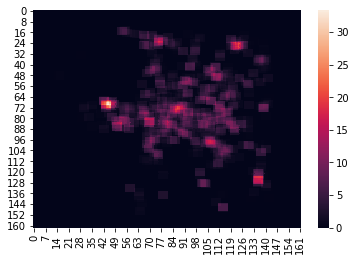

In [ ]:
sns.heatmap(density_rs) # heat map of resturants density

In [ ]:
np.where(density_position_rs[0] == MAX_Rho_rs) # find hightest density position of resturants

(array([70]), array([45]))

In [ ]:
# density heatmap of hotels
density_position_h  , MAX_Rho_h , MAX_position_h = local_density( x_y_h , rating = rating_h , rating_depent = False ,  scan_shape = 'rectan' , ranging = 40 , start_point=location )
density_h = density_position_h[0]
position_h = density_position_h[1]

MAX_Rho = 152.77777777777777 , MAX_position = [120.19703654745831, 22.996729396442117]


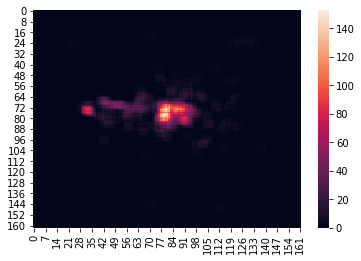

In [ ]:
sns.heatmap(density_h) # heat map of hotels density

In [ ]:
np.where(density_position_h[0] == MAX_Rho_h) # find hightest density position of hotels

(array([74]), array([80]))

In [ ]:
# density heatmap of convenience stores
density_position_cn  , MAX_Rho_cn , MAX_position_cn = local_density( x_y_cn , rating = rating_cn  , rating_depent = False ,  scan_shape = 'rectan' , ranging = 40 , start_point=location )
density_cn = density_position_cn[0]
position_cn = density_position_cn[1]

MAX_Rho = 25.0 , MAX_position = [120.22532467116754, 23.020207814357956]


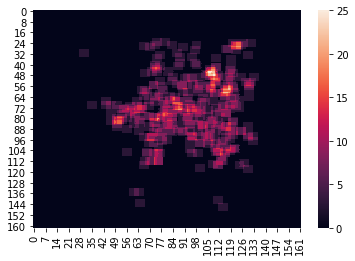

In [ ]:
sns.heatmap(density_cn) # heat map of convenience stores density

In [ ]:
np.where(density_position_cn[0] == MAX_Rho_cn) # find hightest density position of hotels

(array([46, 46, 48]), array([106, 107, 109]))

# finding the top10 hightest density position "consider hotels distribution"


In [ ]:
# finding the top10 hightest density position "consider hotels distribution"
def search_peak(**kwargs):

  '''
  function : search peaks from density grid maps

  **kwargs : the density maps you want to consider , ex : (density_rs = density_rs , density_h = density_h .. )

  return : peaks with [ position_x(grid) ,position_y(grid) , density of resturant center , scors of center]

  '''

  # Importance : resturant > hotel > convenience store > beef soup > pork rice 


  # intial data of train_station 
  station_position = data_train_station[0]['location'] # r square inverse ?


  # initialize data of density
  peaks = []
  density_stack = np.array([ density for _ , density in kwargs.items() ])
  density_name = [ name.split('_')[1] for name in kwargs.keys() ]
  shape_W_L = density_stack.shape[1]

  for i in range(shape_W_L):
    for j in range(shape_W_L):

      surrounding = [ [k,l] for k in range(i-1,i+2) for l in range(j-1,j+2) if (k!=i or l!=j) and (shape_W_L>k>0 and shape_W_L>l>0) ] # find surranding 8 positions
      density_surrounding = [ density_stack[ : , pos_x , pos_y] for pos_x , pos_y in surrounding ]
      score_surroundig = [ reduce(lambda x,y: x+y, densitys) for densitys in density_surrounding ] # function.tools reduce method : https://www.itread01.com/content/1547813009.html
      

      # TODO : 把 socring 計算拆開成獨立函數 , 並在其中加入 weighting 計算式機制!!!


      density_center = density_stack[ : , i , j ]
      score_center = reduce(lambda x,y: x+y, density_center) # 這邊可針對不同類型store的重要度, 給不同的 wighting , ex: 沒 con 絕對不行 , 則評分就變 (hotel + rs)*con => con=0 ,score 直接變成 0    

      if len(list(filter(lambda x : x < score_center , score_surroundig) )) == 8 :
        peaks.append([ i , j , density_center[0], density_center[1] , density_center[2] , distance(grid_to_latlng[i][j],station_position)/1000 ,score_center/(distance(position_rs[i][j],station_position)/1000) ])
      else:

        continue

  return peaks

def store_filter_by_radius( data , center , radius , return_store_position = False):

  filter_position = [ position for position in data if distance( center , position ) < radius ]
  
  return len(filter_position) if not return_store_position else len(filter_position) , filter_position

In [ ]:
peaks = search_peak(density_rs = density_rs ,density_h = density_h , density_cn = density_cn)

In [ ]:
peak_position = []

for peak in sorted(peaks , reverse=True , key = lambda x : x[6]):
  print(peak,grid_to_latlng[peak[0]][peak[1]])
  peak_position.append(grid_to_latlng[peak[0]][peak[1]])

[75, 96, 8.940972222222223, 52.77777777777778, 13.88888888888889, 0.14807264027489397, 510.6118101799548] [120.21264379  22.99582638]
[74, 93, 9.027777777777779, 80.55555555555556, 16.666666666666668, 0.30376768368655876, 349.7738755832683] [120.20971743  22.9967294 ]
[74, 86, 19.661458333333336, 119.44444444444444, 16.666666666666668, 1.0010945989490518, 155.60224738798343] [120.20288926  22.9967294 ]
[77, 91, 10.633680555555555, 72.22222222222223, 11.11111111111111, 0.6091750695991557, 154.25288817337895] [120.20776653  22.99402035]
[77, 89, 7.465277777777778, 88.88888888888889, 8.333333333333334, 0.7817097596881969, 133.92118839830914] [120.20581562  22.99402035]
[80, 91, 9.071180555555555, 91.66666666666667, 8.333333333333334, 0.8184973074001318, 133.25783673254634] [120.20776653  22.9913113 ]
[77, 98, 6.076388888888889, 27.77777777777778, 11.11111111111111, 0.4014706403068452, 112.00140997461406] [120.21459469  22.99402035]
[77, 81, 7.335069444444445, 141.66666666666669, 16.666666

In [ ]:
peak_position = np.array(peak_position)

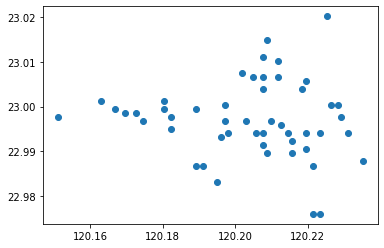

In [ ]:
# plot top peaks position consider hotels and convenience stores 
select_num = 50
plt.scatter(peak_position[:select_num,0],peak_position[:select_num,1])

In [ ]:
search_center = peak_position[0]
_ , res = store_filter_by_radius(x_y_h , search_center , 300 , return_store_position=True )
for name , posi , rat  in zip(name_h ,x_y_h , rating_h):
  if posi in res and rat > 4.5:
    print(name)

慢步南國 台南故事宿
